<a href="https://colab.research.google.com/github/kittikhun62/efficientnet_keras_transfer_learning/blob/master/2Class_datanew.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import from drive

In [25]:
import pandas as pd
import shutil
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
df = pd.read_csv (r'/content/drive/My Drive/data - 2 class เพิ่ม 4 paper.csv')
df

,No,Name_file,Name_Paper,journal,path_Picture,detail,Class,BET,Size(mico),Class_01
0,1,pore-sb,Preparation and electrochemical behaviour of b...,Korean J. Chem. Eng,/content/drive/My Drive/new train/pore-sb/PCC(...,zoom1,0-800,135.06,10,0
1,2,pore-sb,Preparation and electrochemical behaviour of b...,Korean J. Chem. Eng,/content/drive/My Drive/new train/pore-sb/PCC(...,zoom2,0-800,135.06,10,0
2,3,pore-sb,Preparation and electrochemical behaviour of b...,Korean J. Chem. Eng,/content/drive/My Drive/new train/pore-sb/PCC(...,zoom3,0-800,135.06,10,0
3,4,pore-sb,Preparation and electrochemical behaviour of b...,Korean J. Chem. Eng,/content/drive/My Drive/new train/pore-sb/PCC(...,zoom4,0-800,135.06,10,0
4,5,pore-sb,Preparation and electrochemical behaviour of b...,Korean J. Chem. Eng,/content/drive/My Drive/new train/pore-sb/PCC(...,zoom5,0-800,135.06,10,0
...,...,...,...,...,...,...,...,...,...,...
825,826,1-s2.0-S2095268622000210-main,"Integration of preparation of K, Na-embedded a...","Dingzheng Wang,Deqing Zhu,Jian Pan, Zhengqi Gu...",/content/drive/My Drive/new train/1-s2.0-S2095...,zoom21,0-800,301.70,10,0
826,827,1-s2.0-S2095268622000210-main,"Integration of preparation of K, Na-embedded a...","Dingzheng Wang,Deqing Zhu,Jian Pan, Zhengqi Gu...",/content/drive/My Drive/new train/1-s2.0-S2095...,zoom22,0-800,301.70,10,0
827,828,1-s2.0-S2095268622000210-main,"Integration of preparation of K, Na-embedded a...","Dingzheng Wang,Deqing Zhu,Jian Pan, Zhengqi Gu...",/content/drive/My Drive/new train/1-s2.0-S2095...,zoom23,0-800,301.70,10,0
828,829,1-s2.0-S2095268622000210-main,"Integration of preparation of K, Na-embedded a...","Dingzheng Wang,Deqing Zhu,Jian Pan, Zhengqi Gu...",/content/drive/My Drive/new train/1-s2.0-S2095...,zoom24,0-800,301.70,10,0


## hist check class

In [27]:
import matplotlib.pyplot as plt

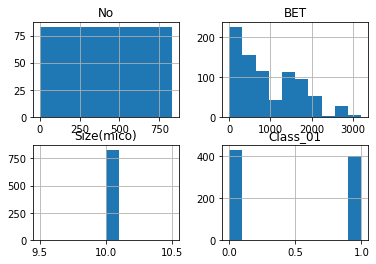

In [28]:
df.hist();

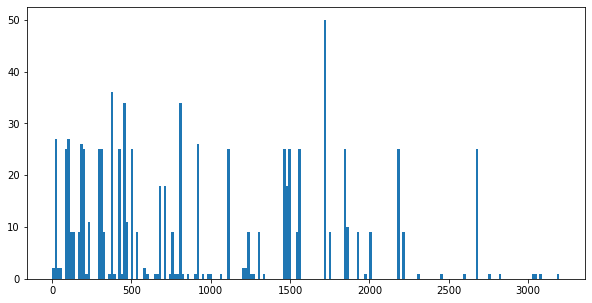

In [29]:
a = df['BET']

fig, ax = plt.subplots(figsize =(10, 5))
ax.hist(a, bins = 200)
plt.show()

In [30]:
classes = ['0-800','801-3200']
len(classes)

2

## Clone efficientnet repo

In [31]:
#ดึงข้อมูลใน Github มาใช้
import os
%cd /content
if not os.path.isdir("efficientnet_keras_transfer_learning"):
 !git clone https://github.com/Wanita-8943/efficientnet_keras_transfer_learning
%cd efficientnet_keras_transfer_learning/

/content
/content/efficientnet_keras_transfer_learning


# การเเบ่งข้อมูล train/validation/test sets

In [32]:
base_dir = '/content/drive/My Drive/new project'
os.makedirs(base_dir, exist_ok=True)

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir, exist_ok=True)
validation_dir = os.path.join(base_dir, 'validation')
os.makedirs(validation_dir, exist_ok=True)
test_dir = os.path.join(base_dir, 'test')
os.makedirs(test_dir, exist_ok=True)

In [33]:
train_1_dir = os.path.join(train_dir, '0-800')
os.makedirs(train_1_dir, exist_ok=True)

train_2_dir = os.path.join(train_dir, '801-3200')
os.makedirs(train_2_dir, exist_ok=True)


validation_1_dir = os.path.join(validation_dir, '0-800')
os.makedirs(validation_1_dir, exist_ok=True)

validation_2_dir = os.path.join(validation_dir, '801-3200')
os.makedirs(validation_2_dir, exist_ok=True)


test_1_dir = os.path.join(test_dir, '0-800')
os.makedirs(test_1_dir, exist_ok=True)

test_2_dir = os.path.join(test_dir, '801-3200')
os.makedirs(test_2_dir, exist_ok=True)



In [34]:
val = df[df['No'].between(629,729)]
train = df[df['No'].between(1,628)]
test = df[df['No'].between(730,830)] 

#Path Train
T1_train = train[train['Class']=='0-800']
T1_path_train = T1_train['path_Picture'].tolist() 
T2_train = train[train['Class']=='801-3200']
T2_path_train = T2_train['path_Picture'].tolist() 


#Path Validation
T1_val = val[val['Class']=='0-800']
T1_path_val = T1_val['path_Picture'].tolist() 
T2_val = val[val['Class']=='801-3200']
T2_path_val = T2_val['path_Picture'].tolist() 



#Path Test
T1_test = test[test['Class']=='0-800']
T1_path_test = T1_test['path_Picture'].tolist() 
T2_test = test[test['Class']=='801-3200']
T2_path_test = T2_test['path_Picture'].tolist() 


### Train

In [35]:
fnames = T1_path_train
for fname in fnames:
    dst = os.path.join(train_1_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

fnames = T2_path_train
for fname in fnames:
    dst = os.path.join(train_2_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
    


### Test

In [36]:
fnames = T1_path_test
for fname in fnames:
    dst = os.path.join(validation_1_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

fnames = T2_path_test
for fname in fnames:
    dst = os.path.join(validation_2_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
    


###Validation

In [37]:
fnames = T1_path_val
for fname in fnames:
    dst = os.path.join(test_1_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

fnames = T2_path_val
for fname in fnames:
    dst = os.path.join(test_2_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)


In [38]:
print('total training 1 images:', len(os.listdir(train_1_dir))) 
print('total training 2 images:', len(os.listdir(train_2_dir)),'\n')

print('total validation 1 images:', len(os.listdir(validation_1_dir)))
print('total validation 2 images:', len(os.listdir(validation_2_dir)),'\n')

print('total test 1 images:', len(os.listdir(test_1_dir)))
print('total test 2 images:', len(os.listdir(test_2_dir)),'\n')


total training 1 images: 331
total training 2 images: 297 

total validation 1 images: 50
total validation 2 images: 51 

total test 1 images: 50
total test 2 images: 51 



# Imports library

In [39]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import os
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

## hyper parameter


In [40]:
batch_size = 16

width = 150
height = 150

epochs = 500 #จำนวนรอบในการ Train

NUM_TRAIN = 628  # จำนวนภาพ Train
NUM_TEST = 101 #จำนวนภาพ Test

dropout_rate = 0.3
input_shape = (height, width, 3) #ขนาด image enter

## Import efficientnet and load the conv base model

In [41]:
# Options: EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3
# Higher the number, the more complex the model is.
from efficientnet import EfficientNetB0 as Net
from efficientnet import center_crop_and_resize, preprocess_input

In [42]:
# loading pretrained conv base model
# โหลดโมเดล มาโดยตัด output ของโมเดลออก เเต่ยังใช้ input อันเดิม
# เเละโหลด weight ของโมเดล มาด้วยที่ชื่อว่า imagenet
#EfficientNet สร้างขึ้นสำหรับการจำแนกประเภท ImageNet ประกอบด้วยป้ายกำกับคลาส 1,000 รายการ เรามีเพียง 2 เลเยอร์เท่านั้น ซึ่งหมายความว่าเลเยอร์สองสามเลเยอร์สุดท้ายสำหรับการจำแนกไม่มีประโยชน์สำหรับเรา สามารถยกเว้นได้ขณะโหลดโมเดลโดยระบุอาร์กิวเมนต์ include_top เป็น False และนำไปใช้กับโมเดล ImageNet อื่นๆ ที่มีอยู่ในแอปพลิเคชัน Keras เช่นกัน

conv_base = Net(weights='imagenet', include_top=False, input_shape=input_shape)

In [43]:
conv_base.summary() #ดู Summary

Model: "efficientnet-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_65 (Conv2D)             (None, 75, 75, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_49 (BatchN  (None, 75, 75, 32)  128         ['conv2d_65[0][0]']              
 ormalization)                                                                                    
                                                                                    

# Show architecture model

In [44]:
#ดัดแปลง GlobalMaxPooling2D เพื่อแปลง 4D the (batch_size, rows, cols,channels) tensor เป็น 2D tensor with shape (batch_size,channels)
#GlobalMaxPooling2D ส่งผลให้มีจำนวนฟีเจอร์น้อยกว่ามากเมื่อเทียบกับเลเยอร์ Flatten ซึ่งช่วยลดจำนวนพารามิเตอร์ได้อย่างมีประสิทธิภาพ

model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D(name="gap"))
# model.add(layers.Flatten(name="flatten"))
if dropout_rate > 0:
    model.add(layers.Dropout(dropout_rate, name="dropout_out"))
# model.add(layers.Dense(256, activation='relu', name="fc1"))
model.add(layers.Dense(2, activation='softmax', name="fc_out"))

In [45]:
print('This is the number of trainable layers '
      'before freezing the conv base:', len(model.trainable_weights))

conv_base.trainable = False

print('This is the number of trainable layers '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable layers before freezing the conv base: 213
This is the number of trainable layers after freezing the conv base: 2


In [46]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 5, 5, 1280)       4049564   
 )                                                               
                                                                 
 gap (GlobalMaxPooling2D)    (None, 1280)              0         
                                                                 
 dropout_out (Dropout)       (None, 1280)              0         
                                                                 
 fc_out (Dense)              (None, 2)                 2562      
                                                                 
Total params: 4,052,126
Trainable params: 2,562
Non-trainable params: 4,049,564
_________________________________________________________________


## Setting data augmentation

In [47]:
# Train ด้วย ImageDataGenerator ของ Keras ซึ่งจะเพิ่มข้อมูลเสริมระหว่างการฝึกเพื่อลดโอกาสเกิด overfitting
#overfitting เกิดจากข้อมูลที่ซับซ้อนกันเกินไป
#Image Augmentation 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255, # image input 0-255 --> 0-1 เปลี่ยนค่าสี
      rotation_range=40,# หมุนภาพในองศา
      width_shift_range=0.2, #เปลี่ยนความกว้าง
      height_shift_range=0.2, #ปลี่ยนความสูง
      shear_range=0.2, #ทำให้ภาพเบี้ยว
      zoom_range=0.2, # Randomly zoom image
      horizontal_flip=True, 
      #โดย Default เมื่อมีการเลื่อนภาพ บิดภาพ หมุนภาพ จะเกิดพื้นที่ว่างที่มุม 
      #ซึ่งจะมีการเติมภาพให้เต็มโดยใช้เทคนิคแบบ Nearest neighbor ซึ่งเป็นการดึงสีบริเวณใหล้าเคียงมาระบายให้เต็ม แต่เราก็ยังสามารถกำหนดวิธีการ Fill ภาพด้วยเทคนิคอื่นได้จาก Parameter fill_mode
      fill_mode='nearest')
# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory #ไดเรกเป้าหมาย
        train_dir,
        # รูปภาพทั้งหมดจะถูกปรับขนาดตามความสูงและความกว้างของเป้าหมาย
        target_size=(height, width),
        batch_size=batch_size,
        # Since we use categorical_crossentropy loss, we need categorical labels
        #เนื่องจากเราใช้ categorical_crossentropy loss เราจึงต้องมีป้ายกำกับตามหมวดหมู่
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory( #การดึงภาพจาก Directory มาเข้าโมเดล 
        validation_dir,
        target_size=(height, width),
        batch_size=batch_size,
        class_mode='categorical')

Found 628 images belonging to 2 classes.
Found 101 images belonging to 2 classes.


# Training

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=2e-6),
              metrics=['acc'])
history = model.fit_generator(
      train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)

<ipython-input-48-50b257eec21b>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/500
39/39 [==============================] - 46s 926ms/step - loss: 1.9006 - acc: 0.4984 - val_loss: 1.6567 - val_acc: 0.5000
Epoch 2/500
39/39 [==============================] - 35s 842ms/step - loss: 1.9636 - acc: 0.4739 - val_loss: 1.5886 - val_acc: 0.5104
Epoch 3/500
39/39 [==============================] - 36s 886ms/step - loss: 1.8756 - acc: 0.4771 - val_loss: 1.5108 - val_acc: 0.5104
Epoch 4/500
39/39 [==============================] - 39s 931ms/step - loss: 1.8355 - acc: 0.5049 - val_loss: 1.4725 - val_acc: 0.5104
Epoch 5/500
39/39 [==============================] - 35s 850ms/step - loss: 1.7029 - acc: 0.4820 - val_loss: 1.4428 - val_acc: 0.5104
Epoch 6/500
39/39 [==============================] - 35s 866ms/step - loss: 1.7412 - acc: 0.4886 - val_loss: 1.3614 - val_acc: 0.5104
Epoch 7/500
39/39 [==============================] - 38s 902ms/step - loss: 1.7598 - acc: 0.4760 - val_loss: 1.3493 - val_acc: 0.5000
Epoch 8/500
39/39 [==============================] - 32s 778ms

In [ ]:
history.history 

### Plot training performance

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'co', label='Training acc')
plt.plot(epochs_x, val_acc, 'k', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'co', label='Training loss')
plt.plot(epochs_x, val_loss, 'k', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**SAVE model** 

In [ ]:
os.makedirs('./content/drive/My Drive/new', exist_ok=True)
model.save('./content/drive/My Drive/new/2Class_datanew.h5')

In [ ]:
from google.colab import files

In [ ]:
files.download("./content/drive/My Drive/new/2Class_datanew.h5")